In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')

Read the data:

In [2]:
names=('Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings')
input_data = pd.read_csv("abalone.data", header=None, names=names)
print(input_data.info())
input_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


a) Do one-hot encoding for the first feature:

In [3]:
input_data = pd.get_dummies(input_data, columns=['Sex'], prefix=['Sex'])
rings = input_data.pop('Rings')
names = list(input_data)
input_data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0


b. Standardization of input:

In [4]:
class Standardizer():
    '''
    Standadize the passed data around mean 0 and unit variance
    '''
    def __init__(self):
        self.mean = 0
        self.std = 1
    
    def fit_transform(self, samples):
        self.mean = samples.mean(axis=0)
        self.std = samples.std(axis=0)
        return (samples - self.mean)/self.std
    
    def transform(self, samples):
        return (samples -self.mean)/self.std

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = Standardizer()

abalone_rem_fts, abalone_test_fts, rem_rings, test_rings = \
train_test_split(input_data.values, rings.values, test_size=0.2, random_state=0)

abalone_rem_fts = scaler.fit_transform(abalone_rem_fts)
abalone_test_fts = scaler.transform(abalone_test_fts)

# Split train dataset for CV
abalone_train_fts, abalone_val_fts, train_rings, val_rings = \
train_test_split(abalone_rem_fts, rem_rings, test_size=0.2, random_state=0)

c. Implement Ridge regression:


In [17]:
# return the weights by closed form solution
def mylinridgereg(X, y, lamda):
    X0 = np.ones((X.shape[0], 1))
    X = np.concatenate((X, X0), axis=1) # For intercept term
    Xt = X.T
    inv = np.linalg.pinv(np.dot(Xt,X) + (lamda * np.eye(X.shape[1])))
    weights = np.dot(np.dot(inv, Xt), y)
    return weights

# predict output based on the weights given
def mylinridgeregeval(X, weights):
    X0 = np.ones((X.shape[0], 1))
    X = np.concatenate((X, X0), axis=1) # For intercept term
    return np.dot(X, weights)

# compute mean squared error
def meansquarederr(T, Tdash):
    return np.sum((T - Tdash) * (T - Tdash))/T.size

d. Identify best lamda value and predict train and test accuracies

In [20]:
lamdas = np.linspace(0.1,30,100)

#get the best lamda value
def get_best_lamda(train_fts, train_op, val_fts, val_op):
    prev_error = np.PINF
    best_lamda = lamdas[0]
    best_weights = np.zeros(train_fts.shape[1])
    for lamda in np.nditer(lamdas):
        weights = mylinridgereg(train_fts, train_op, lamda)
        pred_rings = mylinridgeregeval(val_fts, weights)
        mean_error = meansquarederr(pred_rings, val_op)
        if(mean_error <= prev_error):
            best_lamda = lamda
            prev_error = mean_error
            best_weights = weights 
    return (best_lamda, prev_error, best_weights)

(best_lamda, val_error, weights) = get_best_lamda(abalone_train_fts, train_rings, abalone_val_fts, val_rings)

print("best lamda : %0.4f, validation error: %0.4f " % (best_lamda, val_error))

best lamda : 30.0000, validation error: 4.5284 


In [24]:
pred_rings = mylinridgeregeval(abalone_test_fts, weights)
mean_error = meansquarederr(pred_rings, test_rings)
print(" Test error : %0.4f " % (mean_error))
print("weights: ", weights)

 Test error : 4.9157 
weights:  [ 0.13688955  0.68777587  0.79907964  1.91563958 -3.20049019 -0.51841053
  1.85909846  0.1293775  -0.27725761  0.14210343  9.87456711]


Cross-check with sklearn library:

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_lib = GridSearchCV(Ridge(), {'alpha' : np.linspace(0.1,50,100)}, cv=5)
ridge_lib.fit(abalone_train_fts, train_rings)
predicted_rings = ridge_lib.predict(abalone_test_fts)
print("Test error : %0.4f " % meansquarederr(predicted_rings, test_rings))
print(ridge_lib.best_params_)
print("weights : ", ridge_lib.best_estimator_.coef_, ridge_lib.best_estimator_.intercept_,)

Test error : 4.8963 
{'alpha': 1.6121212121212123}
weights :  [ 0.02210683  0.84995104  0.79321988  4.65203537 -4.68507467 -1.09287764
  1.0660001   0.11634203 -0.263551    0.14147995] 9.97994166899


e. Remove insignificant weights and calculate accuracy:

In [26]:
# Lets remove 0, 7, 8, 9 indcies weights 
insignificant_weights = (0,7,8,9)
trimmed_weights = np.delete(weights, insignificant_weights)

# check test accuracy now
trimmed_abalone_test_fts = np.delete(abalone_test_fts,insignificant_weights, axis=1)

pred_rings = mylinridgeregeval(trimmed_abalone_test_fts, trimmed_weights)
mean_error = meansquarederr(pred_rings, test_rings)
print(" Test error (after removing insignificant weights) : %0.4f " % (mean_error))
print(" weights after trimming : ", trimmed_weights)


 Test error (after removing insignificant weights) : 5.1775 
 weights after trimming :  [ 0.68777587  0.79907964  1.91563958 -3.20049019 -0.51841053  1.85909846
  9.87456711]


#### As we can see even after removing insgnificant weights, MSE increased but not so much as these are contributing very less in prediction of y.

f. MSE error for different lamda values on different partitions:

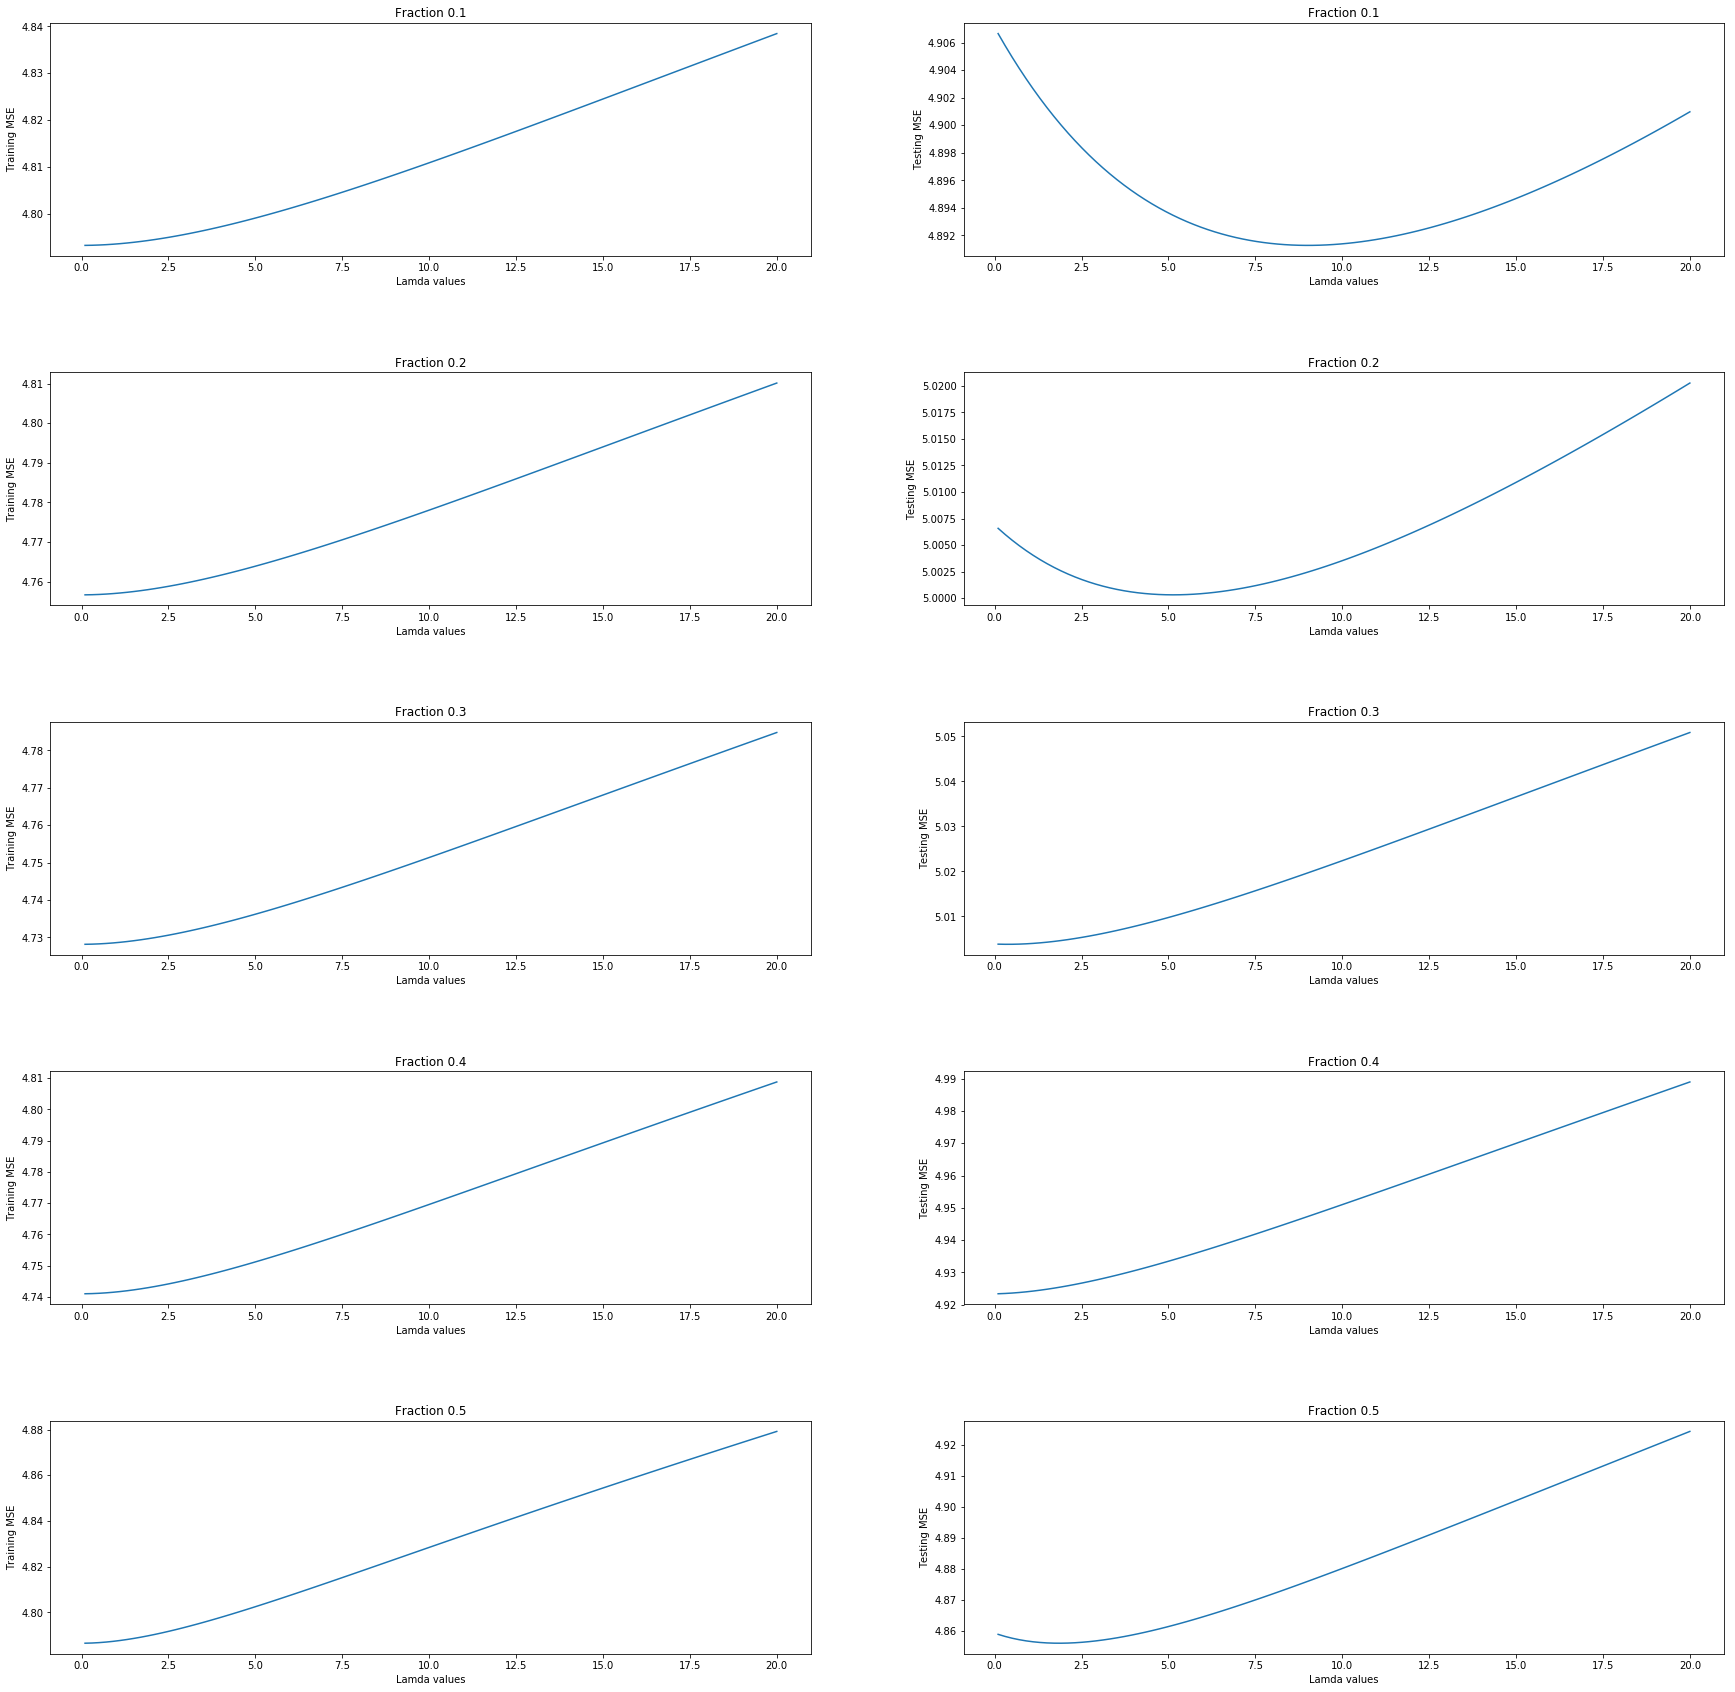

In [28]:
def get_stats_for_fractions_over_lamdas(fractions, lamdas):
    '''
    Return test, train errors for multiple fractions with different lamdas
    This also gives the best lamda based on test error for each fraction size
    '''
    # best lamdas and their test errors for multiple fraction sizes
    nf = len(fractions); nl = len(lamdas)
    best_lamdas = np.zeros((nf,))
    min_test_errors = np.zeros((nf,))

    train_errors = np.zeros((nf,nl)); test_errors =  np.zeros((nf,nl))
    repititions = 25
    
    for i in range(repititions):
    # To overcome the randomness in splitting the data, iterate over 25 trails and take average
    
        for f_index, fraction in enumerate(fractions):
            # Divide the input data set based on fraction size
            train_fts, test_fts, train_rings, test_rings = \
            train_test_split(input_data, rings, test_size=fraction, random_state=0)
            train_fts = scaler.fit_transform(train_fts)
            test_fts = scaler.transform(test_fts)

            min_test_error = np.PINF
            best_lamda = 0.1

            #Enumerate over multiple choices of lamdas and get the best lamda based on test error
            for l_index, lamda in enumerate(lamdas):
                fit_weights = mylinridgereg(train_fts, train_rings, lamda)
                train_pred_rings = mylinridgeregeval(train_fts, fit_weights)
                train_errors[f_index,l_index] += meansquarederr(train_pred_rings, train_rings)

                test_pred_rings = mylinridgeregeval(test_fts, fit_weights)
                test_error = meansquarederr(test_pred_rings, test_rings)
                test_errors[f_index,l_index] += test_error
                if test_error <= min_test_error:
                    min_test_error = test_error
                    best_lamda = lamda

            min_test_errors[f_index] += min_test_error
            best_lamdas[f_index] += best_lamda
        
    return (train_errors/repititions, test_errors/repititions, min_test_errors/repititions, best_lamdas/repititions)
    
tr_fractions = np.array([0.1,0.2,0.3,0.4,0.5])
tr_lamdas = np.linspace(0.1,20,100)

f, plot_arr = plt.subplots(nrows=tr_fractions.size, ncols=2, figsize=(30,30))

(train_errors, test_errors, min_test_errors, best_lamdas) = \
    get_stats_for_fractions_over_lamdas(tr_fractions, tr_lamdas)

for i, fraction in enumerate(tr_fractions):
    plot_arr[i,0].plot(tr_lamdas, train_errors[i, :])
    plot_arr[i,0].set_xlabel("Lamda values")
    plot_arr[i,0].set_ylabel("Training MSE")
    plot_arr[i,0].set_title("Fraction "+str(fraction))
    
    plot_arr[i,1].plot(tr_lamdas, test_errors[i, :])
    plot_arr[i,1].set_xlabel("Lamda values")
    plot_arr[i,1].set_ylabel("Testing MSE")
    plot_arr[i,1].set_title("Fraction "+str(fraction))

f.subplots_adjust(hspace=0.5,wspace=0.2)

plt.show()

From above graphs we can say that when test data set is more resembling to training data set, then we can take lamda value smaller. In other words, when test data set size is less then we have to increase lamda to overcome overfitting to training data and when we have sufficient test data, then we can reduce the weights to regualrize the model.

But in case of training MSE, it always increases with lamda as it reduces weights which causes over fitting

g. Plot min test MSE and best lamda value for fractions:

Text(0.5,1,'Best lamda Vs Fraction size')

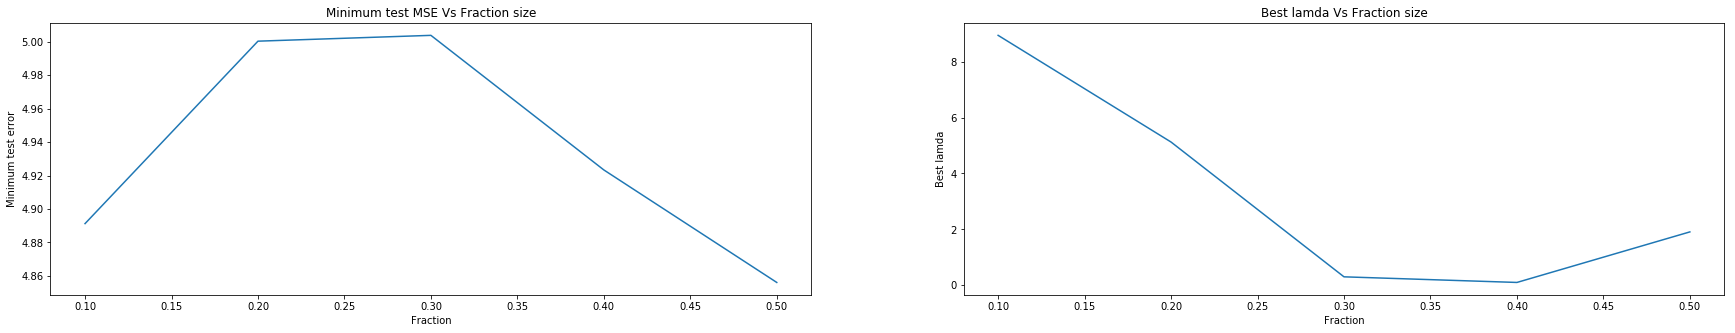

In [29]:
f, plot_arr = plt.subplots(1, 2, figsize=(30,5))
plot_arr[0].plot(tr_fractions, min_test_errors)
plot_arr[0].set_xlabel("Fraction")
plot_arr[0].set_ylabel("Minimum test error")
plot_arr[0].set_title("Minimum test MSE Vs Fraction size")

plot_arr[1].plot(tr_fractions, best_lamdas)
plot_arr[1].set_xlabel("Fraction")
plot_arr[1].set_ylabel("Best lamda")
plot_arr[1].set_title("Best lamda Vs Fraction size")

h. Plot predicted and actual values for best lamda

Text(0.5,1,'Testing set predicitons vs actual outputs')

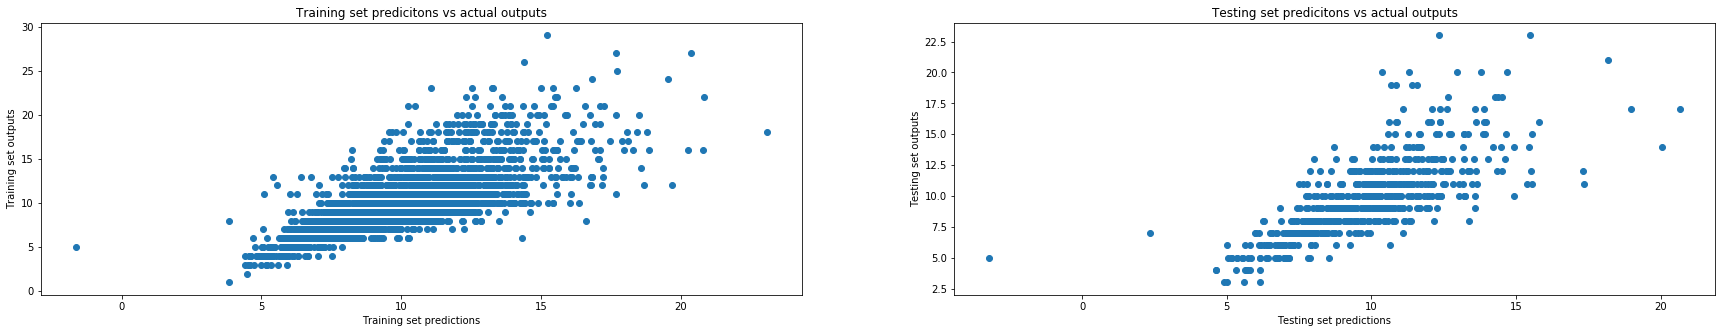

In [30]:
# Lets take fraction = 0.15 (lamda = 10, MSE= 4.90)
train_fts, test_fts, train_rings, test_rings = \
train_test_split(input_data, rings, test_size=0.15, random_state=0)
train_fts = scaler.fit_transform(train_fts)
test_fts = scaler.transform(test_fts)

f, plot_arr = plt.subplots(1, 2, figsize=(30,5))

weights = mylinridgereg(train_fts, train_rings, 0.15)
train_pred_rings = mylinridgeregeval(train_fts, weights)
'''
To test with library
ridge = Ridge(alpha=1.6)
ridge.fit(train_fts, train_rings)
train_pred_rings = ridge.predict(train_fts)
'''

plot_arr[0].plot(train_pred_rings, train_rings, 'o')
plot_arr[0].set_xlabel("Training set predictions")
plot_arr[0].set_ylabel("Training set outputs")
plot_arr[0].set_title("Training set predicitons vs actual outputs")
        
test_pred_rings = mylinridgeregeval(test_fts, weights)
#test_pred_rings = ridge.predict(test_fts)

plot_arr[1].plot(test_pred_rings, test_rings, 'o')
plot_arr[1].set_xlabel("Testing set predictions")
plot_arr[1].set_ylabel("Testing set outputs")
plot_arr[1].set_title("Testing set predicitons vs actual outputs")